In [1]:
import rasterio
from rasterio.plot import show
import rasterio.mask
import pyproj
import shapely
import shapely.geometry
import shapely.ops
import fiona
import numpy as np
import geopandas as gpd

In [2]:
def reproject_geom(geom, src_crs, dst_crs):
    transformer = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    return shapely.ops.transform(transformer.transform, geom)

In [3]:
src = rasterio.open("data/raster/example.tif")

In [4]:
src.shape

(1667, 1909)

In [5]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1909, 'height': 1667, 'count': 1, 'crs': CRS.from_wkt('COMPD_CS["NAD83(CSRS) / UTM zone 12N + CGVD2013 height",PROJCS["NAD83(CSRS) / UTM zone 12N + CGVD2013 height",GEOGCS["NAD83(CSRS)",DATUM["NAD83_Canadian_Spatial_Reference_System",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6140"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4617"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]],VERT_CS["CGVD2013(CGG2013) height",VERT_DATUM["Canadian Geodetic Vertical Datum of 2013 (CGG2013)",2005,AUTHORITY["EPSG","1127"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Up",UP]]]'), 'transform': Affine(5.0,

In [6]:
boundary = gpd.read_file("data/vector/boundary.geojson").to_crs(src.crs)

In [7]:
mask_arr = src.read_masks(1)

In [19]:
boundary_arr = rasterio.features.rasterize(boundary.geometry, out_shape=src.shape, transform=src.transform, all_touched=False, dtype="uint8", fill=0, default_value=255)

In [20]:
boundary_arr.shape

(1667, 1909)

In [29]:
out = (mask_arr - boundary_arr).astype("bool")

In [30]:
out

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [31]:
out.shape

(1667, 1909)

In [32]:
out.any()

np.True_

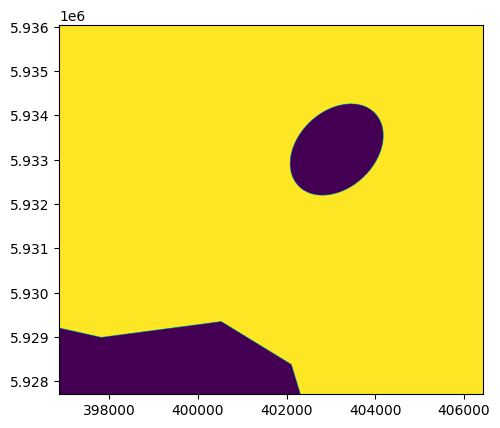

<Axes: >

In [33]:
show(mask_arr, transform=src.transform)

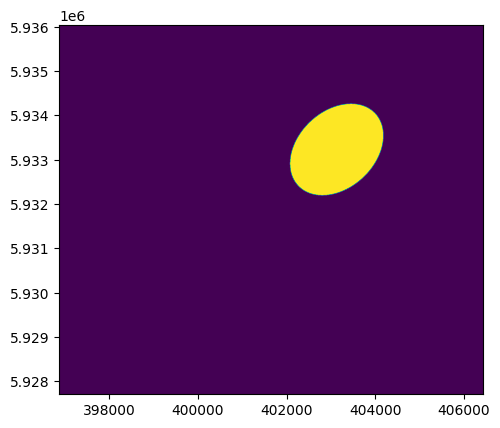

<Axes: >

In [34]:
show(out, transform=src.transform)

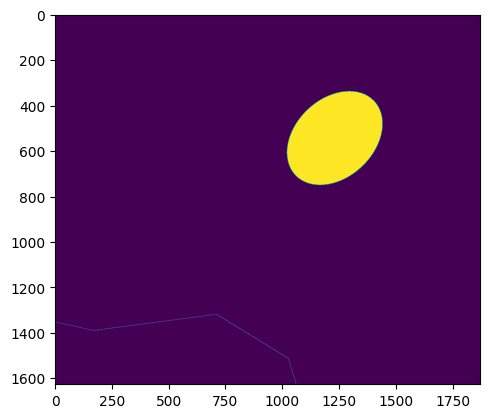

<Axes: >

In [15]:
clip_amount = 20
show(out[clip_amount:out.shape[0]-clip_amount, clip_amount:out.shape[1]-clip_amount])

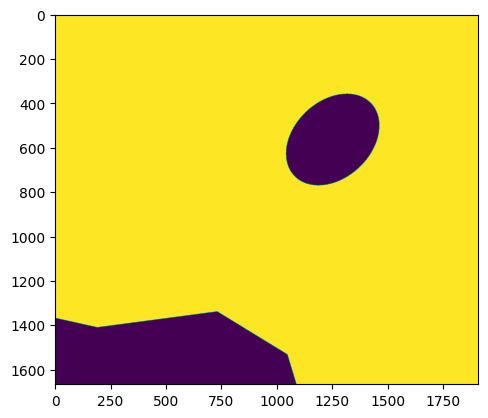

<Axes: >

In [16]:
show(src.read_masks(1))

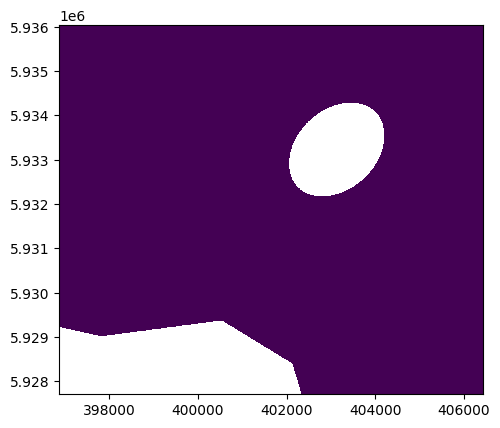

<Axes: >

In [17]:
show(src)

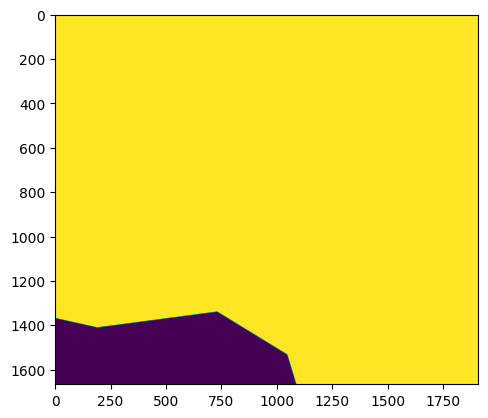

<Axes: >

In [18]:
show(boundary_arr)